# Postprocessing MMC case

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC
import postproamrwindsample_xarray as ppsamplexr

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

In [3]:
def interpProfile(avgtimes, case, zheight, var):
    interpvar =  []
    for avgt in avgtimes:
        dat=case.ABLpostpro_plotprofiles(ax=None, plotvars=[var], avgt=avgt, doplot=False)
        interpvar.append(np.interp(zheight, dat[var]['z'], dat[var]['data']))
    return interpvar

In [4]:
rundir = '/nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_5m'
suffix = '08_5m'

In [5]:
# Start the amrwind_frontend app 
case = amrwind.MyApp.init_nogui()

In [6]:
case.ABLpostpro_loadnetcdffile(rundir+'/post_processing/abl_statistics00000.nc')

Loading /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMC_Stable_2020_02/2020-02-04-8100/MMC_NOW23_08_5m/post_processing/abl_statistics00000.nc
Time range: 0.125000 to 11700.000000
Done.


In [7]:
zMMC     = np.loadtxt(rundir+'/MMC_all_heights.dat')
tMMC     = np.loadtxt(rundir+'/MMC_time_sec.dat')
uMMC     = np.loadtxt(rundir+'/MMC_Ublend%s.dat'%suffix)
vMMC     = np.loadtxt(rundir+'/MMC_Vblend%s.dat'%suffix)
tempMMC  = np.loadtxt(rundir+'/MMC_Tblend%s.dat'%suffix)

twindow = 600
avgtimes = [
            [1*3600-twindow, 1*3600],
            [1.5*3600-twindow, 1.5*3600],
            [2*3600-twindow, 2*3600],
            [3*3600-twindow, 3*3600],
            #[4*3600-twindow, 4*3600],
            #[6*3600-twindow, 6*3600],
            #[7*3600-twindow, 7*3600],
            #[8*3600-twindow, 8*3600],            
            #[10*3600-twindow, 10*3600],            
           ]

Loading u
Loading v
Loading u
Loading v
Loading u
Loading v
Loading u
Loading v


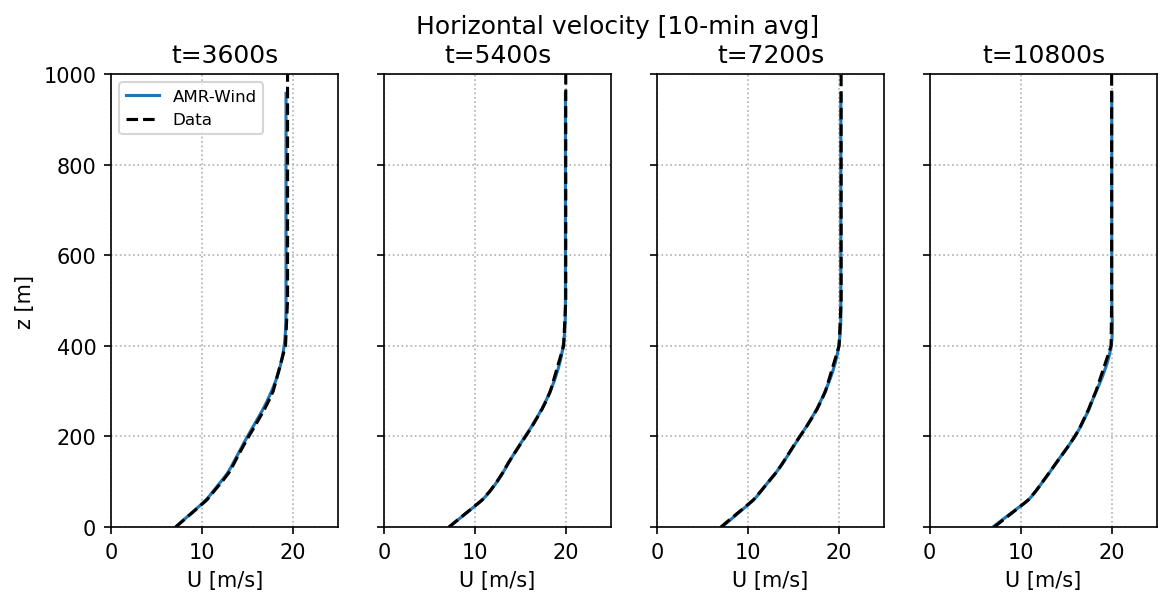

In [8]:
# Plot velocity
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['Uhoriz'], avgt=avgt, doplot=False)
    ax.plot(dat['Uhoriz']['data'], dat['Uhoriz']['z'], label='AMR-Wind')
    
    # Get the nearest MMC data point
    targett = avgt[1]
    iclosest = find_nearest(tMMC, targett)
    uMMC_t   = uMMC[iclosest, :]
    vMMC_t   = vMMC[iclosest, :]
    uh_MMC   = np.sqrt(uMMC_t**2 + vMMC_t**2)
    ax.plot(uh_MMC, zMMC, 'k--', label='Data')
    
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--', label='NOW23')
    ax.set_xlabel('U [m/s]')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    ax.set_xlim([0, 25])
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 1000])
axs[0].legend(prop={'size':8})

fig.suptitle('Horizontal velocity [10-min avg]')
plt.savefig('FarmRun_Plots/ABL_WS.png')

Loading u
Loading v
Loading u
Loading v
Loading u
Loading v
Loading u
Loading v


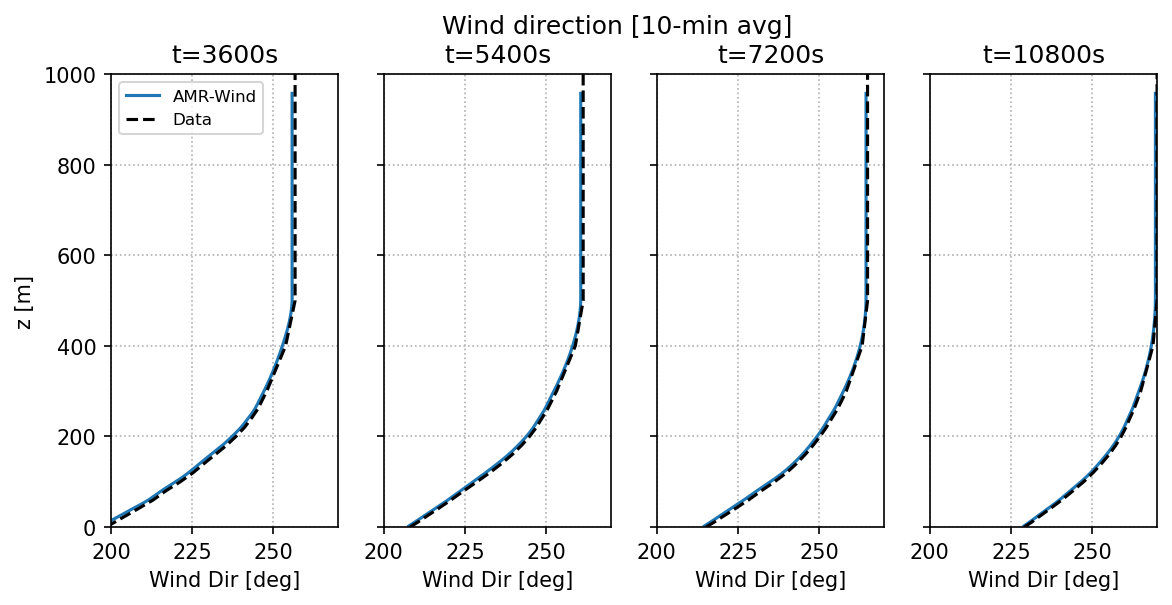

In [9]:
# Plot wind direction
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['WindDir'], avgt=avgt, doplot=False)
    ax.plot(dat['WindDir']['data'], dat['WindDir']['z'], label='AMR-Wind')
    
    # Get the nearest MMC data point
    targett = avgt[1]
    iclosest = find_nearest(tMMC, targett)
    uMMC_t   = uMMC[iclosest, :]
    vMMC_t   = vMMC[iclosest, :]
    wdir_MMC = 270.0-np.arctan2(vMMC_t, uMMC_t)*180.0/np.pi
    ax.plot(wdir_MMC, zMMC, 'k--', label='Data')
    
    ax.set_xlabel('Wind Dir [deg]')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    ax.set_xlim([200, 270])
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 1000])
axs[0].legend(prop={'size':8})
fig.suptitle('Wind direction [10-min avg]')
plt.savefig('FarmRun_Plots/ABL_WD.png')

In [10]:
# Load the NOW23 TKE
NOW23_times   = np.loadtxt('./MMC_profile_dat/MMC_profiles_times.dat')
NOW23_heights = np.loadtxt('./MMC_profile_dat/MMC_profiles_heights.dat')
NOW23_tke     = np.loadtxt('./MMC_profile_dat/MMC_profiles_tke.dat')

Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


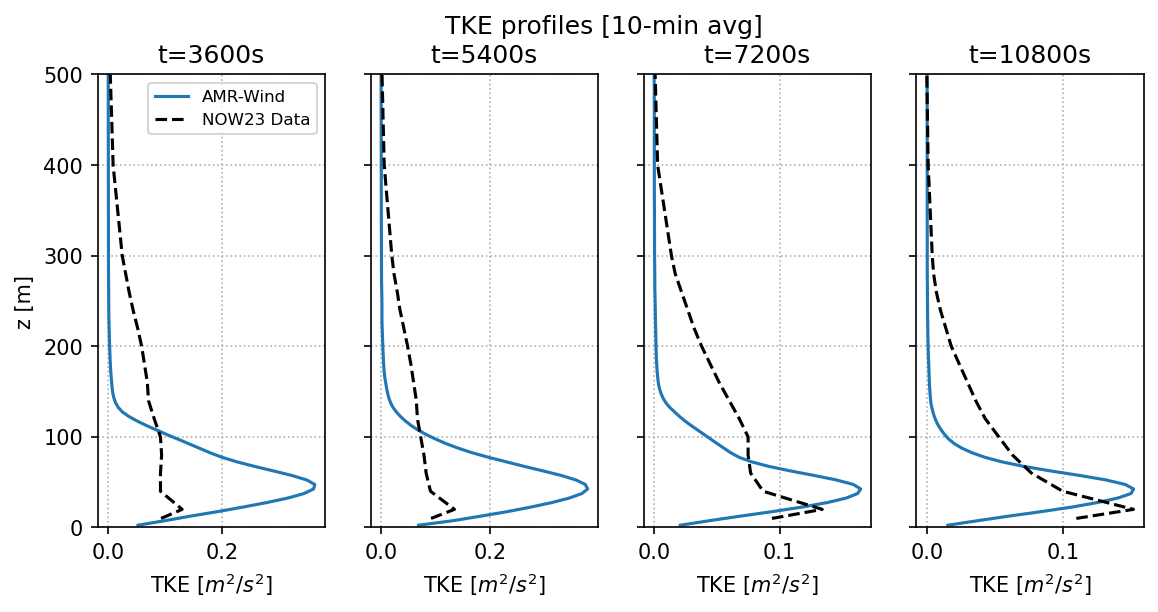

In [11]:
 # Plot TKE
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['TKE'], avgt=avgt, doplot=False)
    ax.plot(dat['TKE']['data'], dat['TKE']['z'], label='AMR-Wind')
    
    # Plot the NOW23 TKE data
    targett = avgt[1]
    iNOW23 = find_nearest(NOW23_times, targett)
    ax.plot(NOW23_tke[iNOW23,:], NOW23_heights, 'k--', label='NOW23 Data')
    
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--')
    ax.set_xlabel('TKE [$m^2/s^2$]')
    ax.set_title('t=%.0fs'%avgt[1])
    #ax.set_xlim([0, 0.6])
    ax.grid(linestyle=':')

axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 500])
axs[0].legend(prop={'size':8})

fig.suptitle('TKE profiles [10-min avg]')
plt.savefig('FarmRun_Plots/ABL_TKE.png')

Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u
Loading v
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


Text(0.5, 0.98, 'TI profiles [10-min avg]')

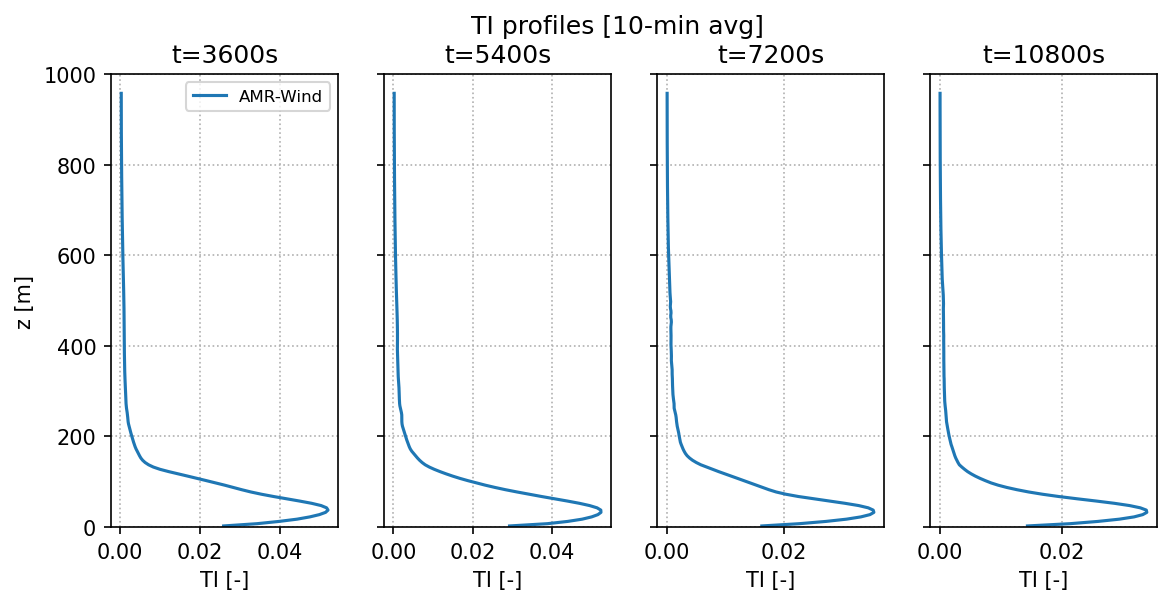

In [12]:
# Plot TI
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['TI_TKE'], avgt=avgt, doplot=False)
    ax.plot(dat['TI_TKE']['data'], dat['TI_TKE']['z'], label='AMR-Wind')
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--')
    ax.set_xlabel('TI [-]')
    ax.set_title('t=%.0fs'%avgt[1])
    #ax.set_xlim([0, 0.3])
    ax.grid(linestyle=':')
    

axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 1000])
axs[0].legend(prop={'size':8})

fig.suptitle('TI profiles [10-min avg]')

Loading theta
Loading theta
Loading theta
Loading theta


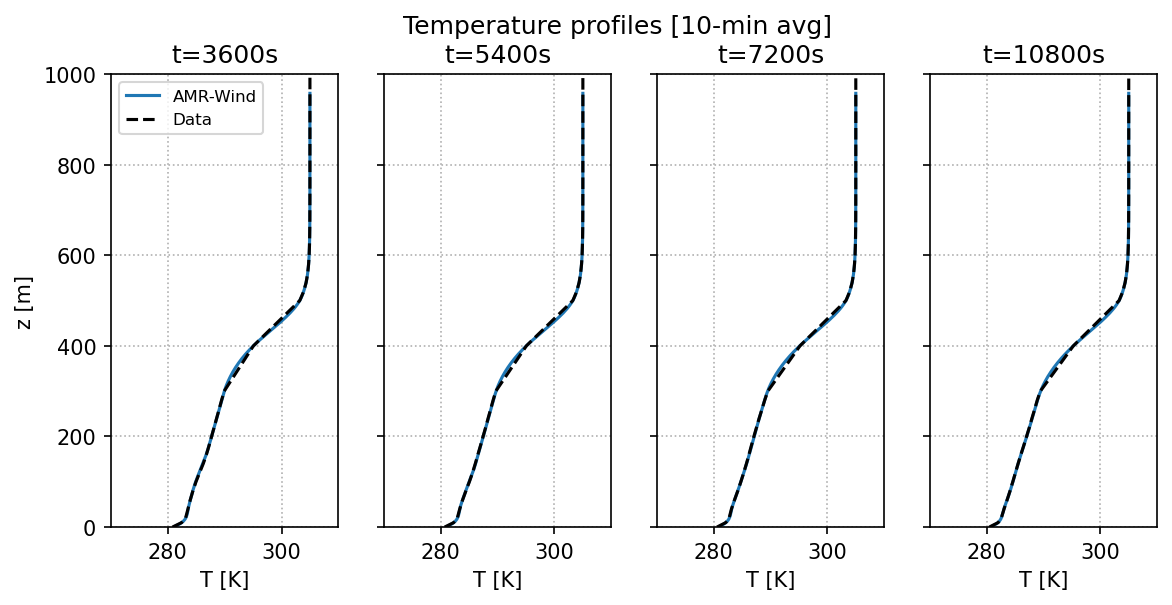

In [13]:
# Plot Temperature
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['Temperature'], avgt=avgt, doplot=False)
    ax.plot(dat['T']['data'], dat['T']['z'], label='AMR-Wind')
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--')
    ax.set_xlabel('T [K]')
    
    targett = avgt[1]
    iclosest = find_nearest(tMMC, targett)
    tempMMC_t   = tempMMC[iclosest, :]
    ax.plot(tempMMC_t, zMMC, 'k--', label='Data')
    
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    ax.set_xlim([270, 310])
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 1000])
axs[0].legend(prop={'size':8})

fig.suptitle('Temperature profiles [10-min avg]')
plt.savefig('FarmRun_Plots/ABL_T.png')